<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-03 20:14:59--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-08-03 20:14:59 (9.67 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



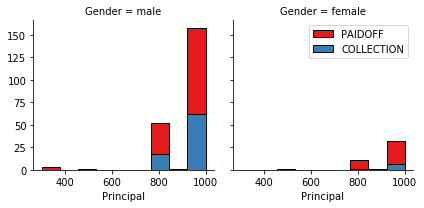

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

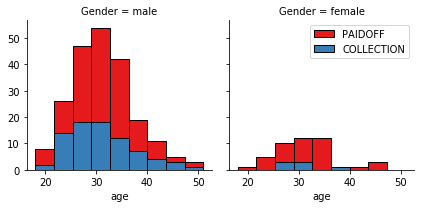

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

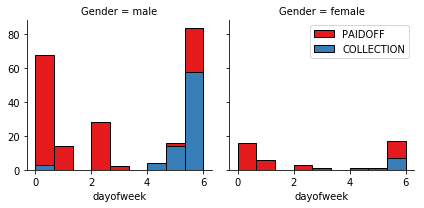

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical variables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our labels?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# First, let's define a function to print some classification statistics and 
# plot the confusion matrix, that can be used to evaluate our models
def plot_confusion_matrix( y_true, y_pred, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    
    # Compute confusion matrix
    classes = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    np.set_printoptions(precision=2)

    print (classification_report(y_true, y_pred))
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [21]:
# In order to train the KNN model, let's split the original data into train (80% of samples) and test (20% of samples) 
# data sets. This is a good technique for avoiding overfitting in the model, and will provide more realistic
# assessment of the algorithm performance for predicting out-of-sample values.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)

print( "X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)

X_train: (276, 8) X_test: (70, 8) y_train: (276,) y_test: (70,)


In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Create a DataFrame for storing the metrics in a nice way
results = pd.DataFrame()

min_k = 1
max_k = 40

# Run with KNN classifier for each value of k (number of neighbors)
for k in range(min_k, max_k+1):
    # Create a KNN classifier and train the model with the train data set
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)

    # Predict the Y-hat values using the test set
    yhat = knn.predict(X_test)

    # Get some metrics about our model
    r = classification_report(y_test, yhat, output_dict=True)
    
    # Fill a dictionary with the desired metrics
    d = { 'k' : [k],
          'COLLECTION_precision' : [r['COLLECTION']['precision']], 
          'COLLECTION_recall' : [r['COLLECTION']['recall']],
          'COLLECTION_f1score' : [r['COLLECTION']['f1-score']], 
          'PAIDOFF_precision' : [r['PAIDOFF']['precision']], 
          'PAIDOFF_recall' : [r['PAIDOFF']['recall']],
          'PAIDOFF_f1score' : [r['PAIDOFF']['f1-score']],         
          'weighted_f1score' : [r['weighted avg']['f1-score']],         
        } 
    
    # Append the result to the table
    results = results.append( pd.DataFrame( data = d ), ignore_index = True )

# Print the table in a pretty formatting 
results

,k,COLLECTION_precision,COLLECTION_recall,COLLECTION_f1score,PAIDOFF_precision,PAIDOFF_recall,PAIDOFF_f1score,weighted_f1score
0,1,0.071429,0.083333,0.076923,0.803571,0.775862,0.789474,0.667322
1,2,0.125000,0.250000,0.166667,0.804348,0.637931,0.711538,0.618132
2,3,0.153846,0.166667,0.160000,0.824561,0.810345,0.817391,0.704696
3,4,0.238095,0.416667,0.303030,0.857143,0.724138,0.785047,0.702415
4,5,0.250000,0.333333,0.285714,0.851852,0.793103,0.821429,0.729592
5,6,0.222222,0.333333,0.266667,0.846154,0.758621,0.800000,0.708571
6,7,0.307692,0.333333,0.320000,0.859649,0.844828,0.852174,0.760944
7,8,0.315789,0.500000,0.387097,0.882353,0.775862,0.825688,0.750501
8,9,0.333333,0.416667,0.370370,0.872727,0.827586,0.849558,0.767411
9,10,0.250000,0.416667,0.312500,0.860000,0.741379,0.796296,0.713360


## Analysis
This table gives us important information about the performance of the KNN model for each value of k (the number of neighbors), up to 40:

| Metric      | Description |
|:-------------:|:-------------|
| precision   | Defined by the formula TP /(TP + FP), is a mesure of the accuracy for predicting the specific class (COLLECTION and PAIDOFF)  |
| recall      | Defined by the formula TP / (TP + FN), is the true positive rate for the specific class (COLLECTION and PAIDOFF)    |
| f1score    | Is the harmonic average between the precision and recall of each class. It is a good way to see if the classifier has both a good precision and recall, and ranges from 0 to 1 (0 = worst, 1 = best) |
| weighted_f1score | Weighted average between the COLLECTION and PAIDOFF f1-scores, according to their frequencies       |

At this point, we must choose which value of k leads to better performance. Some k values will lead to better performance in detecting COLLECTION cases, others will perform better detecting PAIDOFF cases.
So, the **weighted_f1score** metric is capable of aggregating the performance of the other 6 metrics, giving a good balance for detecting correcly both COLLECTION and PAIDOFF cases. 

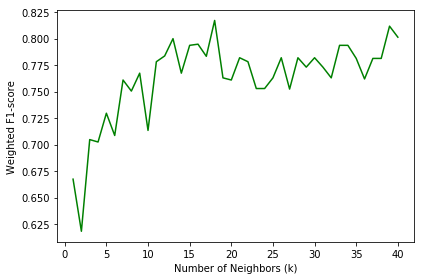

In [23]:
# Plot the accuracy of the model as a function of k, to analyze if there is a trend
plt.plot(results[['k']], results[['weighted_f1score']],'g')
plt.ylabel('Weighted F1-score')
plt.xlabel('Number of Neighbors (k)')
plt.tight_layout()
plt.show()


In [24]:
# Extract the rows that contain the highest accuracy from the results table (there can be more that one row with the same accuracy)
best_results = results[results.weighted_f1score == max(results['weighted_f1score'])]

# Determines the best value of k, i.e, the minimum value of k that leads to the highest accuracy
best_k = min(best_results['k'].values)

print("The best k is", best_k)

# We can see that the best performance of the KNN algotithm, for this data set, is achieved with k=18

The best k is 18


              precision    recall  f1-score   support

  COLLECTION       0.46      0.50      0.48        12
     PAIDOFF       0.89      0.88      0.89        58

   micro avg       0.81      0.81      0.81        70
   macro avg       0.68      0.69      0.68        70
weighted avg       0.82      0.81      0.82        70



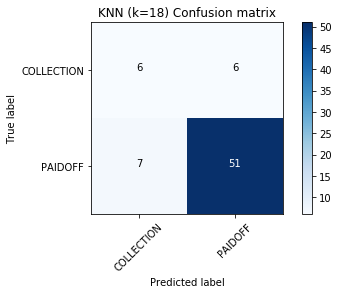

In [25]:
# So, create the KNN model with the best K and plot the confusion matrix 
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit( X_train, y_train )
yhat = knn.predict( X_test )
plot_confusion_matrix( y_test, yhat, title='KNN (k=%d) Confusion matrix' % best_k )

## Conclusion - KNN Model
We can expect that our model won't be very good at predicting COLLECTION cases, but will perform much better at predicting PAIDOFF cases.

In [26]:
# Create a knn classifier with the best k and train the model again with the entire X dataset, 
# that will be used in the end for the final comparison of algorithms
knn_final = KNeighborsClassifier(n_neighbors = best_k)
knn_final.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=18, p=2,
           weights='uniform')

# Decision Tree

In [27]:
# Install the GraphViz module, that will be used for visualization of the decision tree
# It may take a few minutes...
!conda install -c anaconda python-graphviz -y

Solving environment: done

# All requested packages already installed.



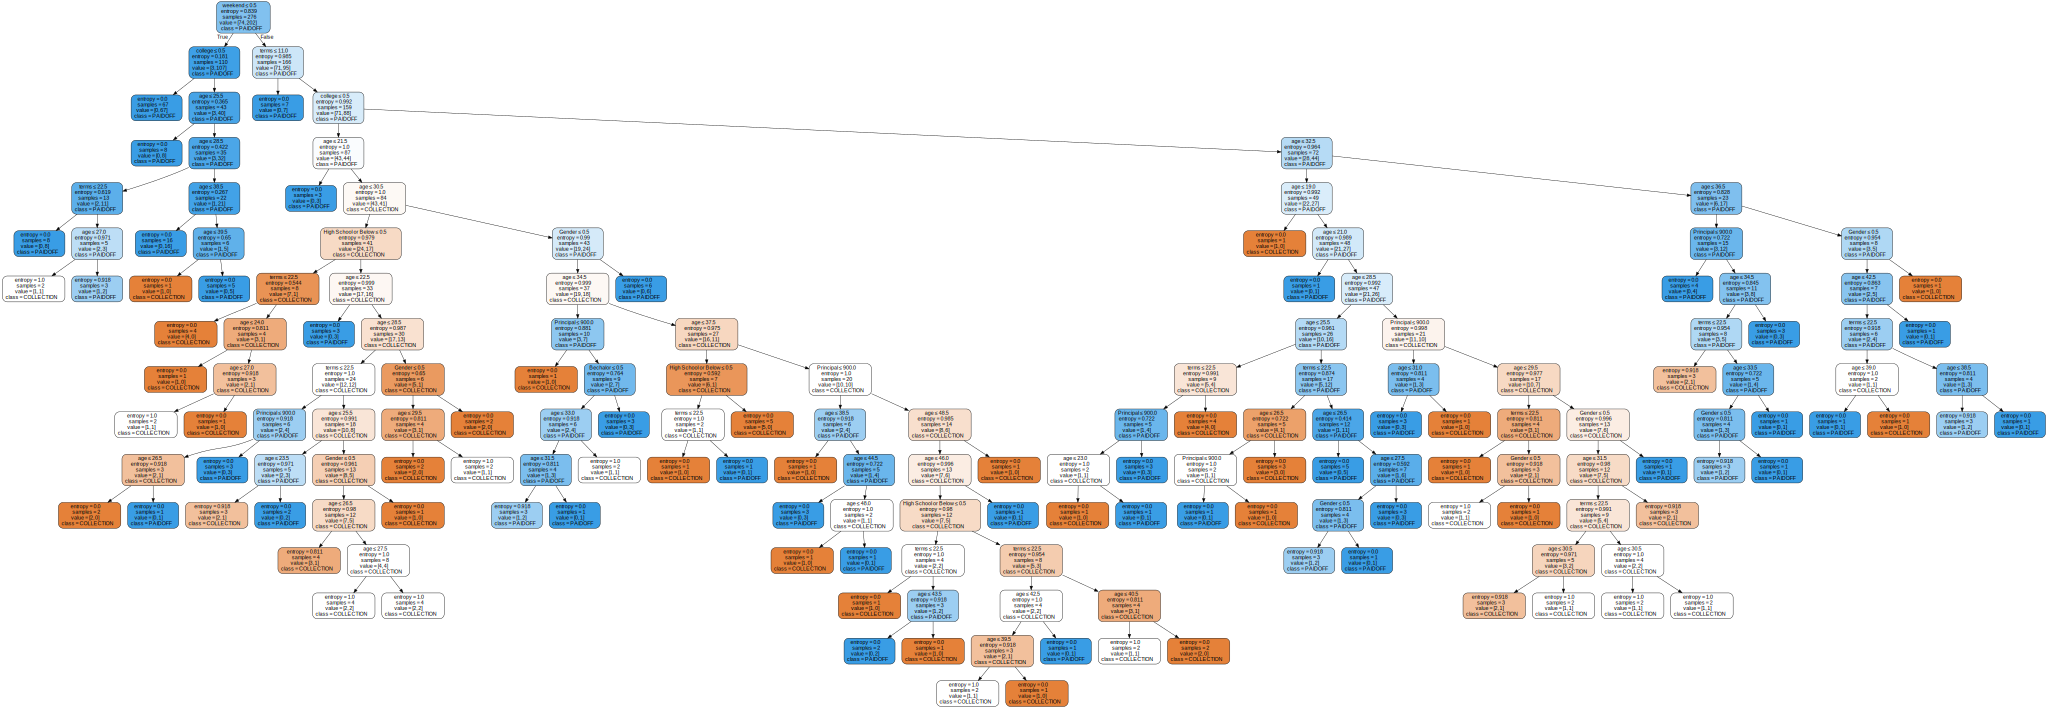

In [28]:
# Import the necessary objects and functions
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn import metrics


# Select the data that will be used. Instead of using X, which contains normalized data, we'll use the original Feature set, 
# to make it easier to visualize the decision tree
X_dt = Feature
y_dt = y

# Extract the features and classes names, for displaying the tree
feature_names_dt = X_dt.columns
target_names_dt = np.unique(y_dt)

# Split the data in two datasets: train (80%) and test data (20%)
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.2, random_state=0)

# Build and train decision tree model. We are not going to specify a max depth and let the algorithm create
# a tree as deep as necessary
dec_tree = DecisionTreeClassifier(criterion="entropy")
dec_tree.fit( X_train_dt, y_train_dt )

# Plot the decision tree
dot = export_graphviz(dec_tree, out_file=None, feature_names=feature_names_dt, class_names=target_names_dt, filled=True, rounded=True, special_characters=True) 
graph = Source(dot)
graph

              precision    recall  f1-score   support

  COLLECTION       0.21      0.33      0.26        12
     PAIDOFF       0.84      0.74      0.79        58

   micro avg       0.67      0.67      0.67        70
   macro avg       0.53      0.54      0.52        70
weighted avg       0.73      0.67      0.70        70



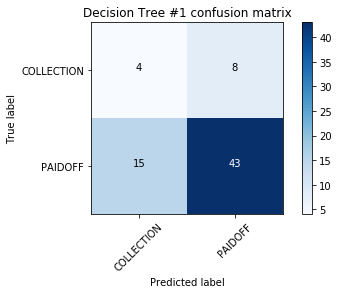

In [29]:
# Plot the confusion matrix and evaluation metrics for our model
yhat_dt = dec_tree.predict( X_test_dt )
plot_confusion_matrix( y_test_dt, yhat_dt, title='Decision Tree #1 confusion matrix' )

**Analysis:** This decision tree seems to be too complex and performs worse than as our KNN model. Looking at the decision tree we can see many leafs with still a high entropy, which means we can expect a large error in these cases. Let's see if we can tweak the model to improve it. 

 ## Decision tree - second attempt
One hypothesis for the not so good performance in detecting COLLECTION cases is that this dataset is unbalanced, i.e., approximately 25% of the cases are labelled COLLECTION and 75% are PAIDOFF, which could bias the model.
An alternative is to use the 'balanced' mode for class_weight parameter of the algorithm, which will use values of y to automatically adjust weights inversely proportional to class frequencies in the input data. This will give higher importance for the COLLECTION cases. Let's see if this change can improve the algorithm:

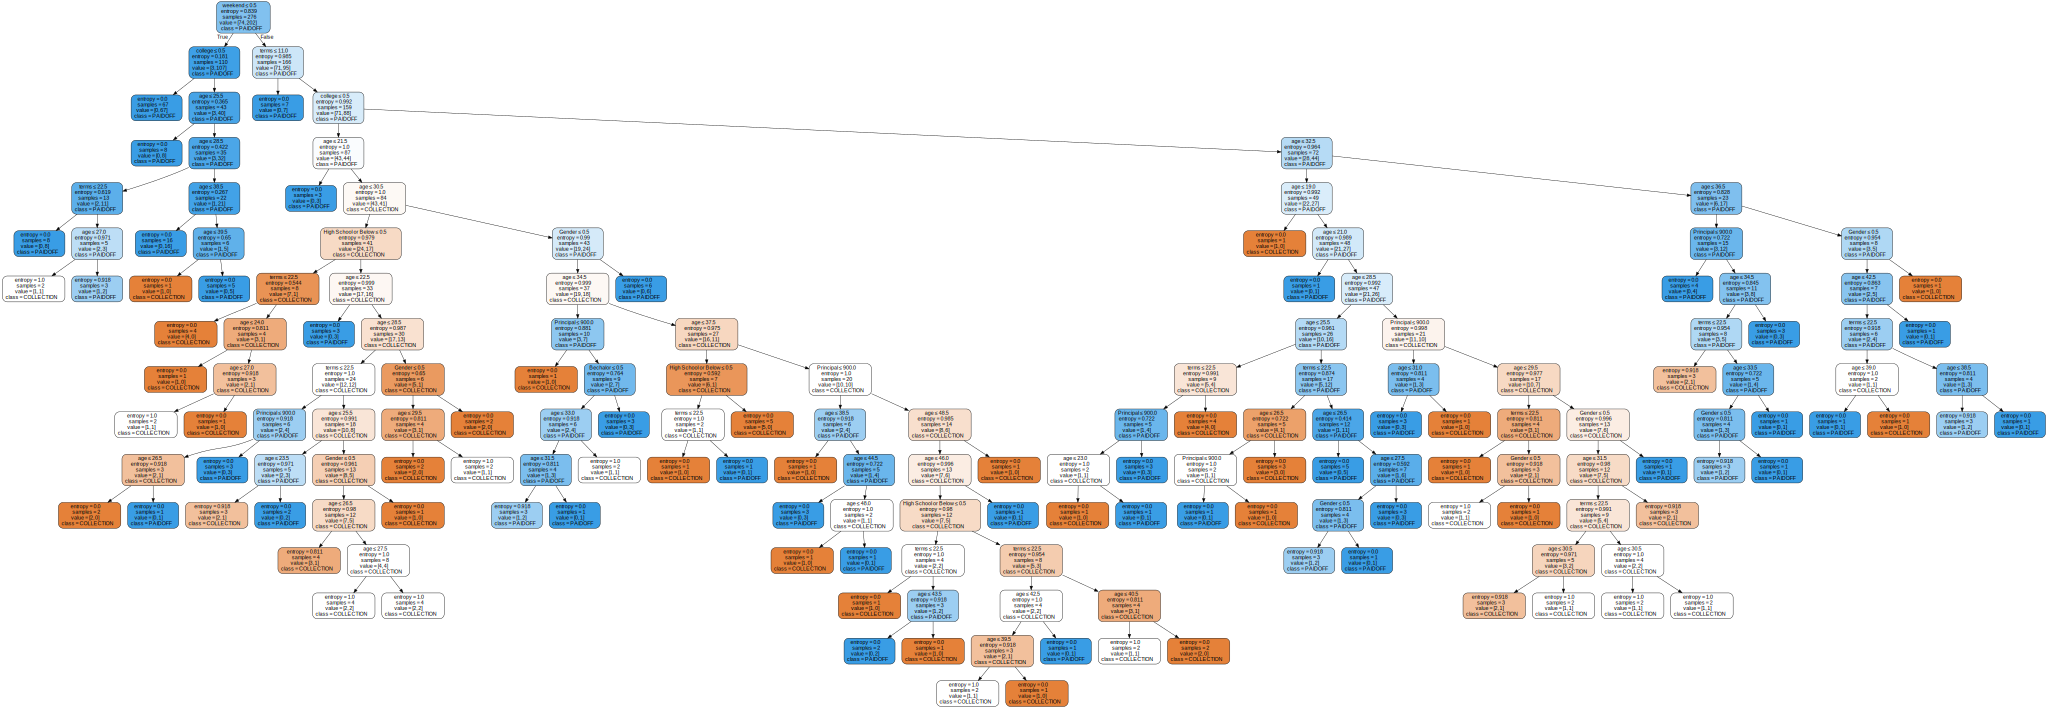

In [30]:
# Build and train decision tree model
dec_tree2 = DecisionTreeClassifier(criterion="entropy", class_weight='balanced')
dec_tree2.fit( X_train_dt, y_train_dt )

# Plot the decision tree
dot2 = export_graphviz(dec_tree2, out_file=None, feature_names=feature_names_dt, class_names=target_names_dt, filled=True, rounded=True, special_characters=True) 
graph2 = Source(dot)
graph2

              precision    recall  f1-score   support

  COLLECTION       0.22      0.42      0.29        12
     PAIDOFF       0.85      0.69      0.76        58

   micro avg       0.64      0.64      0.64        70
   macro avg       0.53      0.55      0.52        70
weighted avg       0.74      0.64      0.68        70



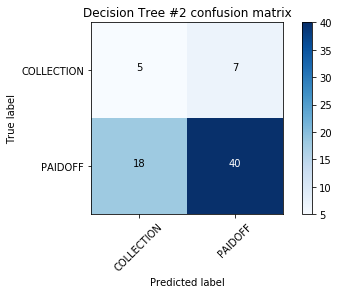

In [31]:
# Calculate the model accuracy using the test dataset
yhat2_dt = dec_tree2.predict( X_test_dt )
plot_confusion_matrix( y_test_dt, yhat2_dt, title='Decision Tree #2 confusion matrix' )

**Analysis:** The second decision tree performs better than the first one in predicting COLLECTION cases, but performs worse in predicting the PAIDOFF cases. This is expected, as we build the tree in balanced mode to compensate the smaller number of COLLECTION cases. Nevertheless, the Weighted F1-Score of the second decision tree is slightly worse (0.69) than the first decision tree (0.70). Let's see if we can further improve the model.  


## Decision Tree - Third Attempt

In this third attempt to improve the algorithm, let's explore the effect of the decision tree depth on the accuracy.

In [32]:
# Specify the max_depth limits for the iteration
min_depth = 2
max_depth = 30

# Create a dataframe to hold the results
results_dt = pd.DataFrame()

# Iterate through different max_depth values and get the model's metrics 
for depth in range(min_depth, max_depth+1):
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
    dt.fit( X_train_dt, y_train_dt )
    yhat_dt = dt.predict( X_test_dt )
    
    # Get some metrics about our model
    r = classification_report(y_test_dt, yhat_dt, output_dict=True)
    
    # Fill a dictionary with the desired metrics
    d = { 'max_depth' : [depth],
          'COLLECTION_precision' : [r['COLLECTION']['precision']], 
          'COLLECTION_recall' : [r['COLLECTION']['recall']],
          'COLLECTION_f1score' : [r['COLLECTION']['f1-score']], 
          'PAIDOFF_precision' : [r['PAIDOFF']['precision']], 
          'PAIDOFF_recall' : [r['PAIDOFF']['recall']],
          'PAIDOFF_f1score' : [r['PAIDOFF']['f1-score']],         
          'weighted_f1score' : [r['weighted avg']['f1-score']],         
        } 
    
    # Append the result to the table
    results_dt = results_dt.append( pd.DataFrame( data = d ), ignore_index = True )

# Print the table in a pretty formatting 
results_dt

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

,max_depth,COLLECTION_precision,COLLECTION_recall,COLLECTION_f1score,PAIDOFF_precision,PAIDOFF_recall,PAIDOFF_f1score,weighted_f1score
0,2,0.000000,0.000000,0.000000,0.828571,1.000000,0.906250,0.750893
1,3,0.000000,0.000000,0.000000,0.828571,1.000000,0.906250,0.750893
2,4,0.318182,0.583333,0.411765,0.895833,0.741379,0.811321,0.742825
3,5,0.400000,0.333333,0.363636,0.866667,0.896552,0.881356,0.792604
4,6,0.318182,0.583333,0.411765,0.895833,0.741379,0.811321,0.742825
5,7,0.294118,0.416667,0.344828,0.867925,0.793103,0.828829,0.745857
6,8,0.318182,0.583333,0.411765,0.895833,0.741379,0.811321,0.742825
7,9,0.300000,0.500000,0.375000,0.880000,0.758621,0.814815,0.739418
8,10,0.190476,0.333333,0.242424,0.836735,0.706897,0.766355,0.676538
9,11,0.210526,0.333333,0.258065,0.843137,0.741379,0.788991,0.697975


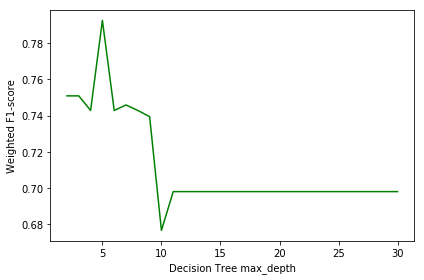

In [33]:
# Plot the accuracy of the model as a function of max_depth, to analyze if there is a trend
plt.plot(results_dt[['max_depth']], results_dt[['weighted_f1score']],'g')
plt.ylabel('Weighted F1-score')
plt.xlabel('Decision Tree max_depth')
plt.tight_layout()
plt.show()

The best max_depth is 5 

              precision    recall  f1-score   support

  COLLECTION       0.40      0.33      0.36        12
     PAIDOFF       0.87      0.90      0.88        58

   micro avg       0.80      0.80      0.80        70
   macro avg       0.63      0.61      0.62        70
weighted avg       0.79      0.80      0.79        70



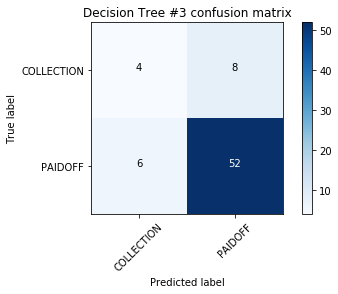

In [34]:
# Determines the best max_depth
best_results = results_dt[results_dt.weighted_f1score == max(results_dt.weighted_f1score)]
best_depth = min(best_results['max_depth'].values)

print("The best max_depth is %d \n" % best_depth)

# So, let's build the tree with this max_depth to see the metrics
dec_tree3 = DecisionTreeClassifier(criterion="entropy", max_depth=best_depth)
dec_tree3.fit( X_train, y_train )
yhat3_dt = dec_tree3.predict( X_test )

plot_confusion_matrix( y_test_dt, yhat3_dt, title='Decision Tree #3 confusion matrix' )

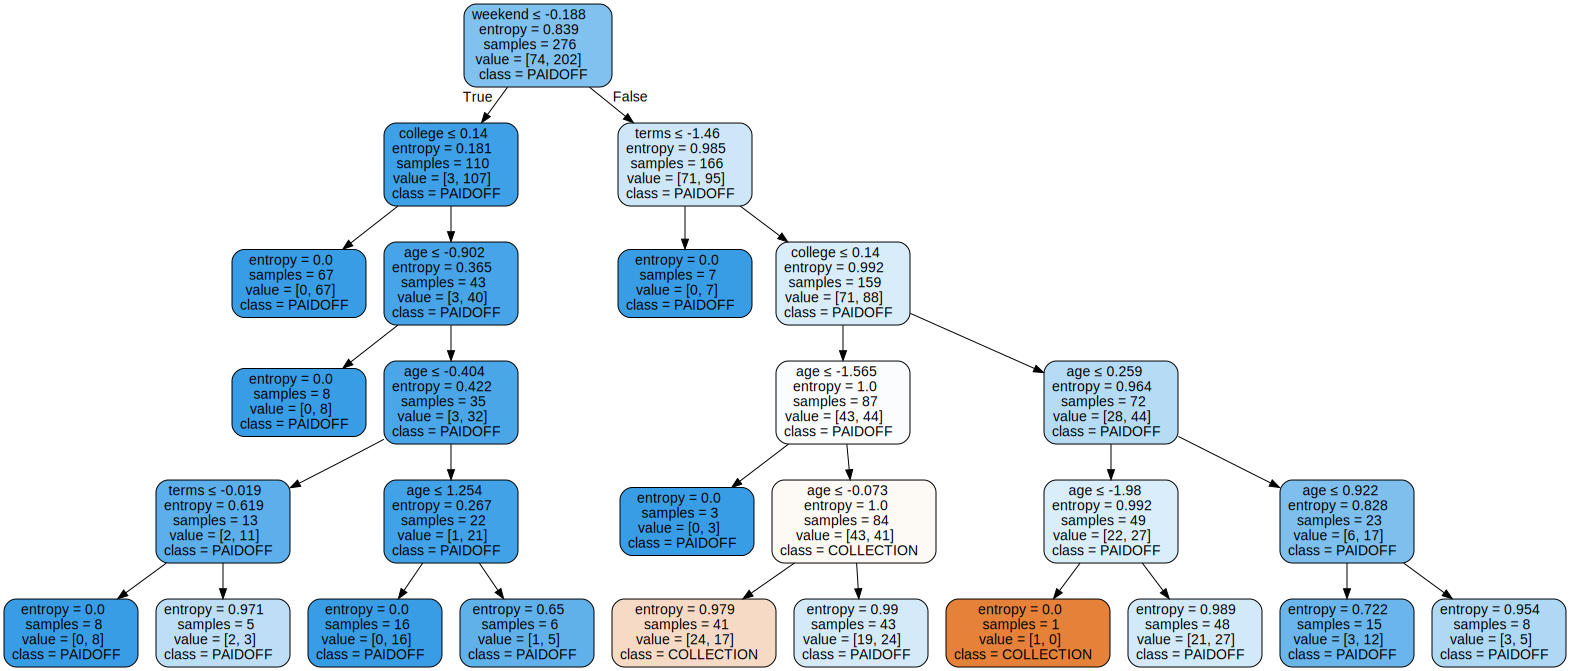

In [35]:
# Plot the decision tree
dot = export_graphviz(dec_tree3, out_file=None, feature_names=feature_names_dt, class_names=target_names_dt, filled=True, rounded=True, special_characters=True) 
graph = Source(dot)
graph

**Analysis:** The resulting model, with a max_depth equals to 5, has a much better weighted avg F1-score. Let's stick with the third attempt model.

In [36]:
# Instantiate and train the final model with the full data set
dt_final = DecisionTreeClassifier(criterion="entropy", max_depth=best_depth)
dt_final.fit( X, y )

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

 # Support Vector Machine

For the Support Vector Machine, there are a few kernel functions available and no easy way to know which one will perform better beforehand. So, let's try with each one:

## SVM - RBF kernel

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

  COLLECTION       0.17      0.17      0.17        12
     PAIDOFF       0.83      0.83      0.83        58

   micro avg       0.71      0.71      0.71        70
   macro avg       0.50      0.50      0.50        70
weighted avg       0.71      0.71      0.71        70



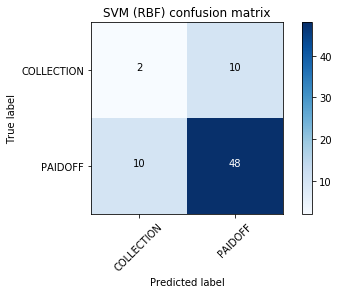

In [37]:
# Import the necessary objects
from sklearn import svm

# Create the SVM model with Radial Based Function kernel function
svm1 = svm.SVC(kernel='rbf')
svm1.fit(X_train, y_train) 
yhat1_svm = svm1.predict( X_test )

plot_confusion_matrix( y_test, yhat1_svm, title='SVM (RBF) confusion matrix' )

**Analysis:** The confusion matrix and F1-score of each COLLECTION and PAIDOFF classes show that this SVM model is the worst so far in predicting COLLECTION cases, and a has a good performance in predicting PAIDOFF cases. The Weighted avg F1-score is 0.71.

## SVM - Linear kernel

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        12
     PAIDOFF       0.83      1.00      0.91        58

   micro avg       0.83      0.83      0.83        70
   macro avg       0.41      0.50      0.45        70
weighted avg       0.69      0.83      0.75        70



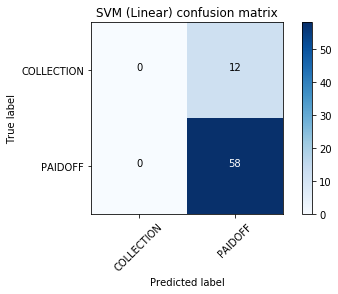

In [38]:
svm2 = svm.SVC(kernel='linear')
svm2.fit(X_train, y_train) 
yhat2_svm = svm2.predict( X_test )

plot_confusion_matrix( y_test, yhat2_svm, title='SVM (Linear) confusion matrix' )

**Analysis:** The Weighted F1-Score of this SVM model is 0.75, which looks better than the first SVM model, but the result is misleading. Looking more carefully at the confusion matrix and individual F1-scores of the COLLECTION and PAIDOFF classes, we can see that this model is unable to predict COLLECTION cases for this test set. So, we cannot consider this model for this dataset.

## SVM - Polynomial kernel

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

  COLLECTION       0.33      0.08      0.13        12
     PAIDOFF       0.84      0.97      0.90        58

   micro avg       0.81      0.81      0.81        70
   macro avg       0.58      0.52      0.51        70
weighted avg       0.75      0.81      0.77        70



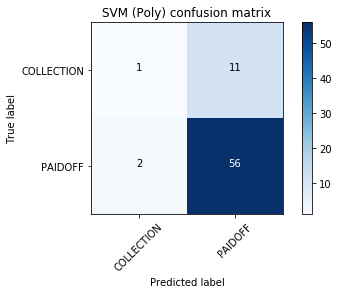

In [39]:
svm3 = svm.SVC(kernel='poly')
svm3.fit(X_train, y_train) 
yhat3_svm = svm3.predict( X_test )

plot_confusion_matrix( y_test, yhat3_svm, title='SVM (Poly) confusion matrix' )

**Analysis:** The polynomial SVM model is the best so far in predicing PAIDOFF cases, with a 97% recall and 84% precision for this test set. The overall F1-score is 0.77, but, again, the result is misleading, because of the unbalanced proportion of PAIDOFF/COLLECTION cases in the data set. The performance in predicting COLLECTION cases is very poor also.

## SVM - Sigmoid kernel

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

  COLLECTION       0.56      0.42      0.48        12
     PAIDOFF       0.89      0.93      0.91        58

   micro avg       0.84      0.84      0.84        70
   macro avg       0.72      0.67      0.69        70
weighted avg       0.83      0.84      0.83        70



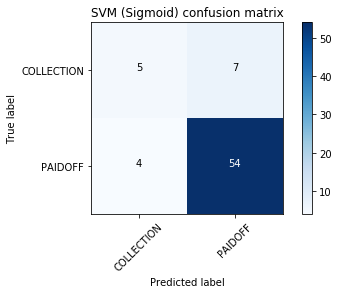

In [40]:
svm4 = svm.SVC(kernel='sigmoid')
svm4.fit(X_train, y_train) 
yhat4_svm = svm4.predict( X_test )

plot_confusion_matrix( y_test, yhat4_svm, title='SVM (Sigmoid) confusion matrix' )

**Analysis:** The Sigmoid kernel SVM model looks promising: the weighted avg F1-score is 0.83, the highest so far. Looking at the confusion matrix and individual F1-scores for the COLLECTION and PAIDOFF classes, we can see that it has the best performance among all models for predicting the PAIDOFF cases (0.91) and also one of the best performances in predicting the COLLECTION cases. Let's pick this model to represent the SVM in our final comparison.

In [41]:
# Instantiate and train the final model with the full data set
svm_final = svm.SVC(kernel='sigmoid')
svm_final.fit(X, y) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

 # Logistic Regression

With Logistic Regression models, we have lots of different parameters to tweak. I'll try to change the solver algorithm, and also set the "C" constant to influence the performance. Let's analyze how both parameters influence the model performance:

In [42]:
# Import the LogisticRegression object
from sklearn.linear_model import LogisticRegression

# Define the values of the regularization constant 'C' that we're going to use
c_values = [0.01, 1.0, 10.0, 100.0]
solvers = ['liblinear', 'newton-cg', 'saga', 'lbfgs']

# Create a DataFrame to hold the results
results_lr = pd.DataFrame()

# Iterate through different solvers and C regularization constant values and get the model's metrics 
for s in solvers:
    for c in c_values:
        lr = LogisticRegression( C=c, solver=s )
        lr.fit( X_train, y_train )
        yhat_lr = lr.predict( X_test )

        # Get some metrics about our model
        r = classification_report(y_test, yhat_lr, output_dict=True)

        # Fill a dictionary with the desired metrics
        d = { 'Solver': [s], 
              'C' : [c],
              'COLLECTION_precision' : [r['COLLECTION']['precision']], 
              'COLLECTION_recall' : [r['COLLECTION']['recall']],
              'COLLECTION_f1score' : [r['COLLECTION']['f1-score']], 
              'PAIDOFF_precision' : [r['PAIDOFF']['precision']], 
              'PAIDOFF_recall' : [r['PAIDOFF']['recall']],
              'PAIDOFF_f1score' : [r['PAIDOFF']['f1-score']],         
              'weighted_f1score' : [r['weighted avg']['f1-score']],         
            } 

        # Append the result to the table
        results_lr = results_lr.append( pd.DataFrame( data = d ), ignore_index = True )

# Print the table in a pretty formatting 
results_lr



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

,Solver,C,COLLECTION_precision,COLLECTION_recall,COLLECTION_f1score,PAIDOFF_precision,PAIDOFF_recall,PAIDOFF_f1score,weighted_f1score
0,liblinear,0.01,0.250000,0.083333,0.125000,0.833333,0.948276,0.887097,0.756452
1,liblinear,1.00,0.545455,0.500000,0.521739,0.898305,0.913793,0.905983,0.840113
2,liblinear,10.00,0.500000,0.500000,0.500000,0.896552,0.896552,0.896552,0.828571
3,liblinear,100.00,0.500000,0.500000,0.500000,0.896552,0.896552,0.896552,0.828571
4,newton-cg,0.01,0.000000,0.000000,0.000000,0.828571,1.000000,0.906250,0.750893
5,newton-cg,1.00,1.000000,0.166667,0.285714,0.852941,1.000000,0.920635,0.811791
6,newton-cg,10.00,0.500000,0.416667,0.454545,0.883333,0.913793,0.898305,0.822232
7,newton-cg,100.00,0.500000,0.500000,0.500000,0.896552,0.896552,0.896552,0.828571
8,saga,0.01,0.000000,0.000000,0.000000,0.828571,1.000000,0.906250,0.750893
9,saga,1.00,1.000000,0.166667,0.285714,0.852941,1.000000,0.920635,0.811791


In [43]:
# Find the best model among all tested, for this dataset
best_lr_result = results_lr[results_lr.weighted_f1score==max(results_lr.weighted_f1score)]
best_lr_result

,Solver,C,COLLECTION_precision,COLLECTION_recall,COLLECTION_f1score,PAIDOFF_precision,PAIDOFF_recall,PAIDOFF_f1score,weighted_f1score
1,liblinear,1.0,0.545455,0.5,0.521739,0.898305,0.913793,0.905983,0.840113


              precision    recall  f1-score   support

  COLLECTION       0.55      0.50      0.52        12
     PAIDOFF       0.90      0.91      0.91        58

   micro avg       0.84      0.84      0.84        70
   macro avg       0.72      0.71      0.71        70
weighted avg       0.84      0.84      0.84        70



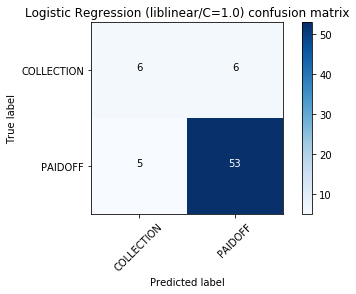

In [44]:
# Plot the confusion matrix for this model, for comparison with the other results
lr = LogisticRegression( C=1.0, solver='liblinear' )
lr.fit( X_train, y_train )
yhat_lr = lr.predict( X_test )

plot_confusion_matrix( y_test, yhat_lr, title='Logistic Regression (liblinear/C=1.0) confusion matrix' )

In [45]:
# Instantiate and train the final model with the full data set
lr_final = LogisticRegression( C=1.0, solver='liblinear' )
lr_final.fit( X, y ) 


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# Model Evaluation using Test set

In [46]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [47]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-08-03 20:20:32--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-08-03 20:20:32 (261 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [48]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [49]:
# Preprocess the test set in the same way we did for training set
# Convert due_date and effective_date features to datatime type
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])

# Create a dayofweek and weekend features
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# Replace male/female by 0/1 numeric values
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# Select only the features that we want to consider
X_test = test_df[['Principal','terms','age','Gender','weekend']]

# Use one-hot encoding to replace categorical values by dummies
X_test = pd.concat([X_test, pd.get_dummies(test_df['education'])], axis=1)
X_test.drop(['Master or Above'], axis = 1,inplace=True)
X_test.head()

# Normalize data and extract the arrays
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
y_test = test_df['loan_status'].values

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:22: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


              precision    recall  f1-score   support

  COLLECTION       0.50      0.07      0.12        14
     PAIDOFF       0.75      0.97      0.85        40

   micro avg       0.74      0.74      0.74        54
   macro avg       0.62      0.52      0.49        54
weighted avg       0.69      0.74      0.66        54



,Algorithm,Jaccard,F1-score,Log Loss
0,KNN,0.740741,0.660427,NA


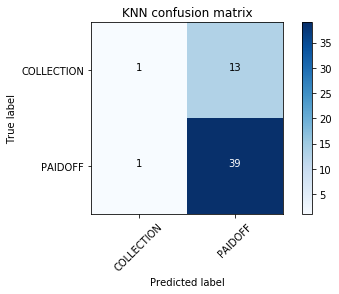

In [50]:
# Now, let's use use the final models of each type (KNN, Decision Tree, SVM, LR) that were created in the previous sections 
# to process the test set and calculate the metrics

# KNN
y_pred_knn = knn_final.predict( X_test )
plot_confusion_matrix( y_test, y_pred_knn, title='KNN confusion matrix' )

jaccard_knn = jaccard_similarity_score( y_true=y_test, y_pred=y_pred_knn )
f1score_knn = f1_score( y_true=y_test, y_pred=y_pred_knn, average='weighted' )  

knn_report = pd.DataFrame( { 'Algorithm':['KNN'], 'Jaccard':[jaccard_knn], 'F1-score':[f1score_knn], 'Log Loss':['NA'] }  )
knn_report

              precision    recall  f1-score   support

  COLLECTION       0.35      0.50      0.41        14
     PAIDOFF       0.79      0.68      0.73        40

   micro avg       0.63      0.63      0.63        54
   macro avg       0.57      0.59      0.57        54
weighted avg       0.68      0.63      0.65        54



,Algorithm,Jaccard,F1-score,Log Loss
0,Decision Tree,0.62963,0.647294,NA


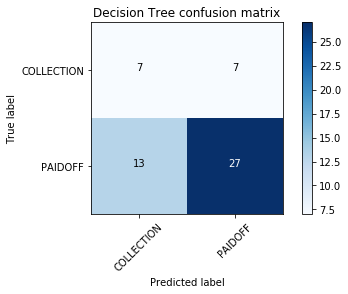

In [51]:
#Decision Tree
y_pred_dt = dt_final.predict( X_test )
plot_confusion_matrix( y_test, y_pred_dt, title='Decision Tree confusion matrix' )

jaccard_dt = jaccard_similarity_score( y_true=y_test, y_pred=y_pred_dt )
f1score_dt = f1_score( y_true=y_test, y_pred=y_pred_dt, average='weighted' )  

dt_report = pd.DataFrame( { 'Algorithm':['Decision Tree'], 'Jaccard':[jaccard_dt], 'F1-score':[f1score_dt], 'Log Loss':['NA'] } )
dt_report

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        14
     PAIDOFF       0.73      0.93      0.81        40

   micro avg       0.69      0.69      0.69        54
   macro avg       0.36      0.46      0.41        54
weighted avg       0.54      0.69      0.60        54



,Algorithm,Jaccard,F1-score,Log Loss
0,SVM,0.685185,0.602361,NA


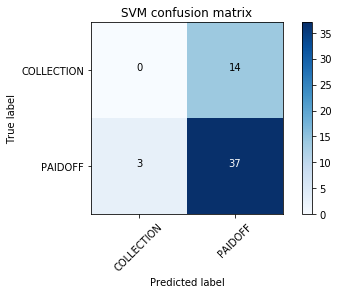

In [52]:
y_pred_svm = svm_final.predict( X_test )
plot_confusion_matrix( y_test, y_pred_svm, title='SVM confusion matrix' )

jaccard_svm = jaccard_similarity_score( y_true=y_test, y_pred=y_pred_svm )
f1score_svm = f1_score( y_true=y_test, y_pred=y_pred_svm, average='weighted' )  

svm_report = pd.DataFrame( {'Algorithm':['SVM'], 'Jaccard':[jaccard_svm], 'F1-score':[f1score_svm], 'Log Loss':['NA'] }  )
svm_report

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        14
     PAIDOFF       0.74      1.00      0.85        40

   micro avg       0.74      0.74      0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predic

,Algorithm,Jaccard,F1-score,Log Loss
0,Logistic Regression,0.740741,0.630418,0.557109


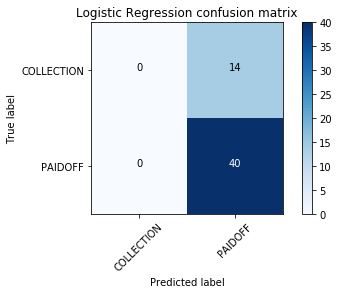

In [53]:
y_pred_lr = lr_final.predict( X_test )
y_proba_lr = lr_final.predict_proba( X_test )
plot_confusion_matrix( y_test, y_pred_lr, title='Logistic Regression confusion matrix' )

jaccard_lr = jaccard_similarity_score( y_true=y_test, y_pred=y_pred_lr )
f1score_lr = f1_score( y_true=y_test, y_pred=y_pred_lr, average='weighted' )  
logloss_lr = log_loss( y_true=y_test, y_pred=y_proba_lr )

lr_report = pd.DataFrame( {'Algorithm':['Logistic Regression'], 'Jaccard':[jaccard_lr], 'F1-score':[f1score_lr], 'Log Loss':[logloss_lr] }, )
lr_report

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

In [54]:
# Create a report DataFrame to print the results
report = pd.DataFrame()
report = report.append(knn_report).append(dt_report).append(svm_report).append(lr_report)
report

,Algorithm,Jaccard,F1-score,Log Loss
0,KNN,0.740741,0.660427,NA
0,Decision Tree,0.629630,0.647294,NA
0,SVM,0.685185,0.602361,NA
0,Logistic Regression,0.740741,0.630418,0.557109


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>